Loading Airbus images and masks: 100%|██████████| 3981/3981 [01:17<00:00, 51.32it/s]


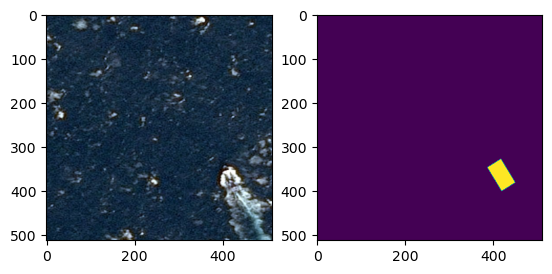

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
import sys
import torch

functions_path = os.path.abspath(os.path.join('..', 'Functions'))
sys.path.append(functions_path)

from functions import load_data_airbus, merge2datasets
from Pytorch_lightning import get_model, DataModule, SegmentationModel, evaluate_model_performance

# Define directories containing images and masks
image_dir_airbus = '../../Data_set/Airbus/'

# Loading data
images_airbus, masks_airbus = load_data_airbus(image_dir_airbus)
images_airbus = np.array([img.astype(np.float32) for img in images_airbus])

# images, masks = merge2datasets(dataset_images_boat1, dataset_masks_boat1, dataset_images_boat2, dataset_masks_boat2)
images, masks = images_airbus, masks_airbus

plt.subplot(121)
plt.imshow(images[0])

plt.subplot(122)
plt.imshow(masks[0])

images_airbus, masks_airbus = [], []

In [2]:
images = images.transpose(0, 3, 1, 2)
masks = masks.transpose(0, 3, 1, 2)

In [3]:
model = get_model(
    num_classes=1,
    neural_network='Unet',
    encoder_name='efficientnet-b7',
    encoder_depth=5,
    activation='sigmoid'
)

data_augmentation = {
    # Geometric transformations
    'RandomRotation': (0, 180),
    'RandomVerticalFlip': 0.5,
    'RandomHorizontalFlip': 0.5,
    'RandomCrop': (256, 256),
    'RandomAffine': {
        'degrees': (-30, 30),     
        'translate': (0.1, 0.1), 
        'scale': (0.8, 1.2), 
        'shear': (-10, 10), 
        'p' : 0            
    },
    'RandomPerspective': {
        'distortion_scale': 0.5,
        'p': 0
    },

    # Radiometric transformations
    'ColorJitter': {
        'brightness': (0.5, 1.5),
        'contrast': (0.5, 1.5),
        'saturation': (0.5, 1.5),
        'hue': (-0.3, 0.3),
        'p': 0.5
    },
    'RandomGamma': {
        'gamma': (0.7, 1.5),
        'p': 0
    },
    'RandomGrayscale': 0,
    'RandomBrightness': {
        'brightness': (0.5, 1.5),
        'p': 0
    },
    'RandomContrast': {
        'contrast': (0.5, 1.5),
        'p': 0
    },
    'RandomSharpness': {
        'sharpness': (0.5, 2.0),
        'p': 0
    },
    'GaussianBlur': {
        'kernel_size': (5, 5),
        'sigma': (0.1, 2.0),
        'p' : 0.5
    }
}

# Data module creation
data_module = DataModule(images, masks, data_augmentation)

log_dir = "tensorboard/logs"
logger = pl.loggers.TensorBoardLogger(log_dir, name="Boat_detector")

# Segmentation model creation
segmentation_model = SegmentationModel(
    model=model,
    optimizer_name='AdamW',
    log_every_n_steps=30,
    learning_rate=0.0001,
    loss='CombinedLoss',
    data_augmentation=data_augmentation,
    log_dir=log_dir,
    logger=logger
)

# Create a callback to save the best weights
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filename='best_model',
    save_top_k=1,
    mode='min'
)

# Using a network with pre-trained weights in a .ckpt file
# name_best_model = '../Pre_train_weights/best_model.ckpt'
# segmentation_model.load_state_dict(torch.load(name_best_model))

# Training configuration
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=100,
    log_every_n_steps=30,
    logger=logger,
    devices=1,
    precision="16-mixed",
    accelerator="auto"
)

# Clear GPU cache to free up more memory space
torch.cuda.empty_cache() 

# Model training with images and masks
trainer.fit(segmentation_model, datamodule=data_module)

# Save weights in a .ckpt file
torch.save(segmentation_model.state_dict(), '../Pre_train_weights/best_model.ckpt')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tensorboard/logs/Boat_detector
2024-09-26 12:43:52.244420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 12:43:54.446809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | transform | DataAugmentation | 0     
1 | model     | Unet             | 67.1 M
2 | loss      | CombinedLoss     | 0     
-----------------------------------------------
67.1 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/work/scratch/env/rouxmoj/conda_env/pytorch/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 5, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/work/scratch/env/rouxmoj/conda_env/pytorch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:385: You have overridden `on_after_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/work/scratch/env/rouxmoj/conda_env/pytorch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging inter

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


/work/scratch/env/rouxmoj/conda_env/pytorch/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 5, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


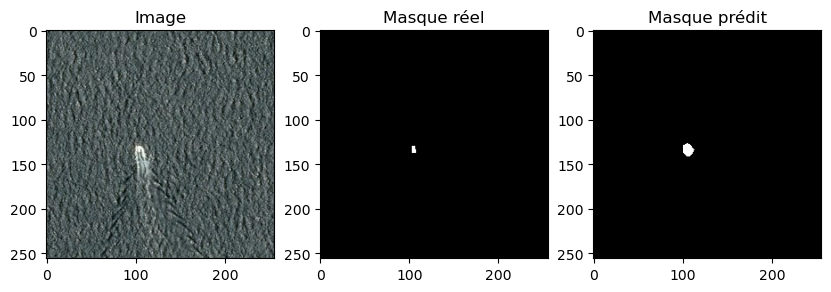

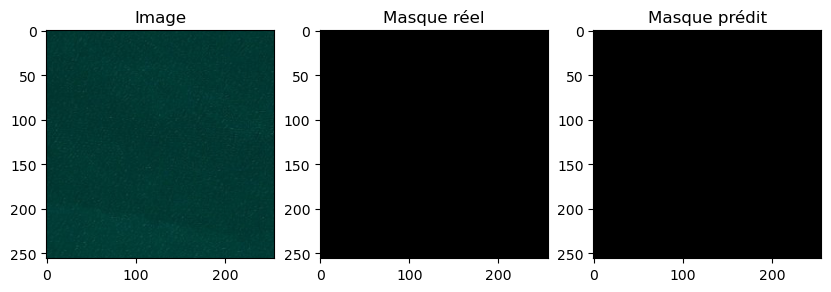

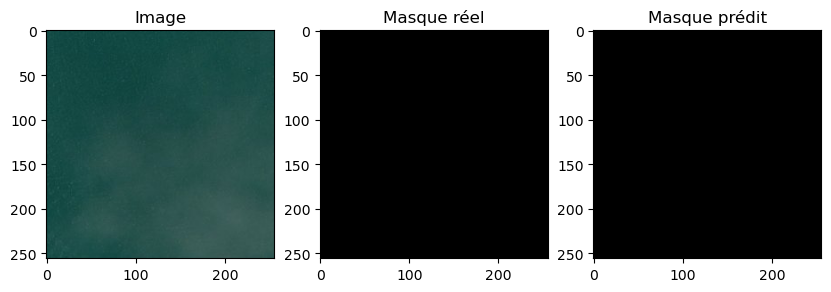

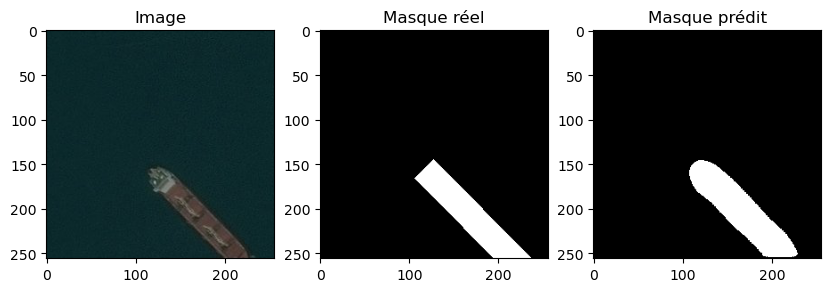

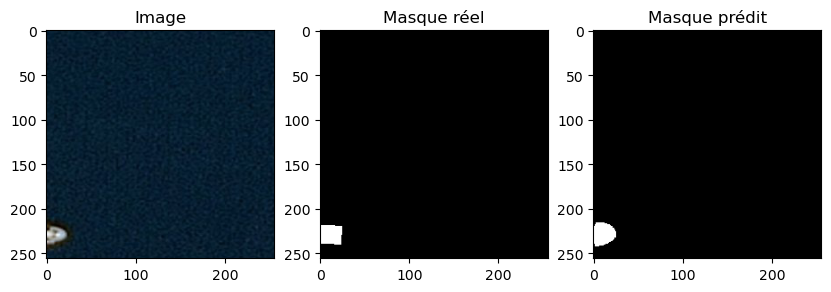

Mean F1-score : 0.8430058028593457
Mean Recall : 0.9802829728411124
Mean IoU : 0.3790728569030762


In [9]:
results = evaluate_model_performance(model, data_module, num_samples=5, threshold=0.5)